In [1]:
import torch
from sklearn.datasets import make_circles

# 1. CREATING DATASET
> This is going to be a toy dataset composed of circles: The aim is to create circles with different shapes
> Hence we gonna create a machine learning algorithm to classify features belonging to one or the other circle

In [2]:
x,y = make_circles(
    n_samples=1000,
    noise = 0.02,
    random_state = 43
)

In [3]:
len(x[:,0])

1000

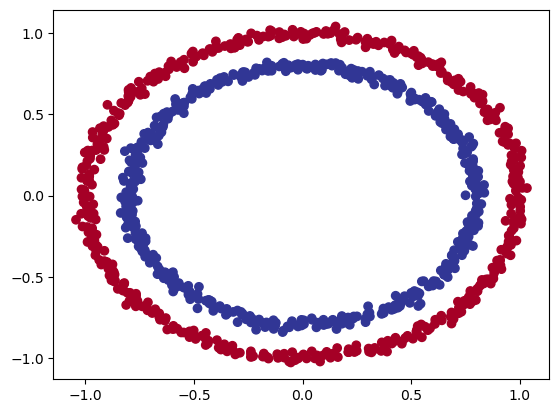

In [4]:
import matplotlib.pyplot as  plt
plt.scatter(x = x[:,0],
            y = x[:,1],
            c = y,
            cmap = plt.cm.RdYlBu
           )

# 2. Tunning our data into tensors

In [5]:
X = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[-0.1396, -0.7845],
         [ 0.7775, -0.1522],
         [-0.6601,  0.7607],
         [ 0.7959,  0.0412],
         [-0.6618,  0.3694]]),
 tensor([1., 1., 0., 1., 1.]))

# 3. Spliting data into training and testing split

In [6]:
# Spliting our data into a training and test set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 123)

In [7]:
# checking the size of the splited data
X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [8]:
# checking the shape
type(X_train)

torch.Tensor

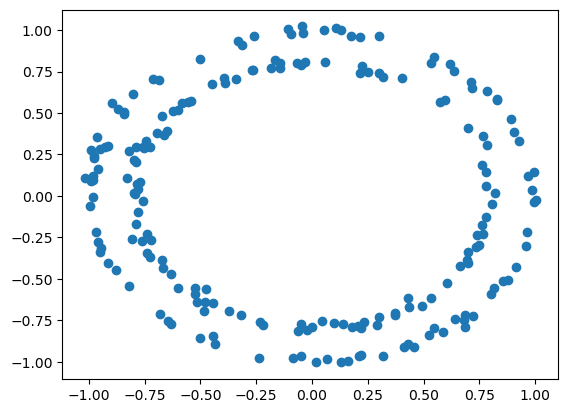

In [9]:
plt.scatter(X_test[:,0],
            X_test[:,1])

# 4. Setting up device agnostic

In [10]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

X_train,y_train = X_train.to(device),y_train.to(device)
X_test, y_test = X_test.to(device),y_test.to(device)

# 5. Building a model

1. Building a model class subclassing the nn.Module
2. Define a loss function and optimizer
3. Implementing the training loop

### 5. 1 Model class

In [11]:
from torch import nn
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer_1 = nn.Linear(in_features = 2,
        #                       out_features = 5)
        # self.layer_2 = nn.Linear(in_features = 5,
        #                         out_features = 1)

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features = 2, out_features =5),
            nn.Linear(in_features = 5, out_features =10),
            nn.Linear(in_features = 10, out_features =5),
            nn.Linear(in_features = 5, out_features =1)      
        )

    # Define the forward pass computation
    def forward(self, x):
        
        # return self.layer_2(self.layer_1(x))
        
        return self.two_linear_layers(x)

### 5. 2 Loss and Optimizer

In [12]:
model = BinaryClassifier()
model.to(device)
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.AdamW(params = model.parameters(),lr = 0.01)

In [13]:
# Let 's perform some naive predictions
model(X_train)[:10]

tensor([[0.4491],
        [0.6090],
        [0.6360],
        [0.3476],
        [0.3475],
        [0.5281],
        [0.3483],
        [0.4313],
        [0.5836],
        [0.3855]], grad_fn=<SliceBackward0>)

In [14]:
model.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.6623, -0.4577],
                      [-0.7063,  0.4153],
                      [ 0.1769,  0.6128],
                      [-0.0895, -0.1462],
                      [ 0.4148, -0.6317]])),
             ('two_linear_layers.0.bias',
              tensor([ 0.6307, -0.2192, -0.3817, -0.6712,  0.5914])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.3964, -0.3901,  0.2062,  0.3242,  0.1308],
                      [-0.3649,  0.0682, -0.0844,  0.0528,  0.4241],
                      [ 0.0167, -0.1681,  0.4217,  0.2307, -0.1810],
                      [-0.4193, -0.4056, -0.2204, -0.0243,  0.1943],
                      [-0.4336, -0.1560,  0.3133,  0.0023, -0.0103],
                      [ 0.1323, -0.3387,  0.0680,  0.3783, -0.1764],
                      [ 0.0467,  0.3732, -0.1512,  0.2467,  0.3549],
                      [ 0.3469, -0.0735,  0.4189, -0.1023, -0.0233],
                      [-0.2277, -0.

In [15]:
with torch.inference_mode():
    predictions = model(X_test)

torch.round(predictions)[:10]

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]])

In [16]:
# defining an accurracy function 
def accuracy_fn(y_true,y_preds):
    correct = torch.eq(y_true,y_preds).sum().item()
    acc = (correct/len(y_preds)) * 100
    return acc

In [17]:
torch.manual_seed(42)

epochs = 1000

for e in range(epochs):

    model.train()

    # 1.forward pass
    y_logits = model(X_train).squeeze()
    
    y_pred =torch.round(torch.sigmoid(y_logits))
    

    # 2. calculate the loss/acc
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_preds = y_pred)

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. back propagation
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true = y_test,
                              y_preds = test_pred)
    if e % 100 == 0:
        print(f'Epoch {e} || Loss: {loss:.5f}, Acc: {acc:.2f} || Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%')


Epoch 0 || Loss: 0.72881, Acc: 49.12 || Test loss: 0.69634 Test acc: 53.50%
Epoch 100 || Loss: 0.69277, Acc: 47.88 || Test loss: 0.69644 Test acc: 44.00%
Epoch 200 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%
Epoch 300 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%
Epoch 400 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%
Epoch 500 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%
Epoch 600 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%
Epoch 700 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%
Epoch 800 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%
Epoch 900 || Loss: 0.69277, Acc: 47.75 || Test loss: 0.69647 Test acc: 44.50%


In [18]:
import requests
from pathlib import Path

if Path('helper_function.py').is_file():
    print('Helper function.py already exists, skipping ownloaad')

else:
    print('Downloading helper function')
    request =requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open('./helper_functions.py','wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

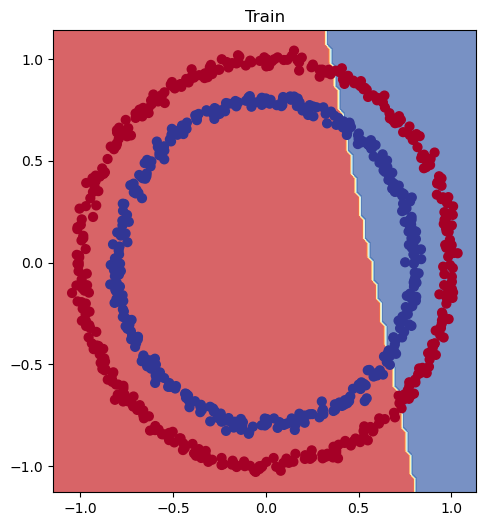

In [20]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model,X_train,y_train)


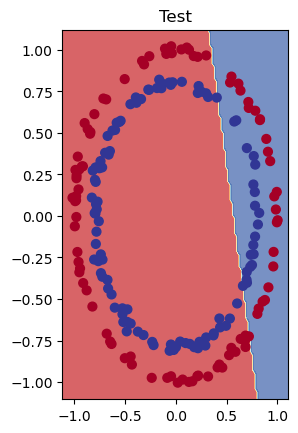

In [21]:

plt.subplot(1,2,1)
plt.title('Test')
plot_decision_boundary(model,X_test,y_test)